## Acquisition success yearly trending

To run this standalone on the HEAD or GRETA networks:
```
# Get into Ska3 environment
git clone https://github.com/sot/aca_stats.git
cd aca_stats
jupyter nbconvert --to notebook --execute acq-success-trend-yearly.ipynb
ls -lrt
```
This will create the png and csv output files.

In [1]:
import numpy as np
from agasc import get_supplement_table
%matplotlib inline
from astropy.table import Table
from mica.stats.acq_stats import get_stats
from cxotime import CxoTime
import matplotlib.pyplot as plt
from chandra_aca.star_probs import binom_ppf

In [2]:
stats = Table(get_stats())
len(stats)

254227

In [3]:
# Make truncated year column for doing grouping. If current time is less than
# half way through the year then slosh that data into the previous year.
curr_year = CxoTime.now().decimalyear
curr_year_trunc = np.trunc(curr_year)
obs_year = CxoTime(stats['guide_tstart']).decimalyear
if curr_year - curr_year_trunc < 0.5:
    obs_year = obs_year.clip(None, curr_year_trunc - 1)
stats['iyear'] = np.trunc(obs_year)

In [4]:
# Correct ACA mags using AGASC supplement
obs_mags = get_supplement_table('mags', as_dict=True)
n_match = 0
for row in stats:
    try:
        row['mag'] = obs_mags[row['agasc_id']]['mag_aca']
        n_match += 1
    except KeyError:
        pass
print(n_match)

208575


In [5]:
# Select only faint stars.
# Original version of notebook filtered on stats['halfw'] >= 120 but don't do that here.
ok = (stats['mag'] >= 9.6) & (stats['mag'] < 10.6)
sok = stats[ok]

In [6]:
len(sok)

63093

In [7]:
n_match

208575

In [8]:
sok['imag'] = np.trunc(sok['mag'] * 5) / 5

In [9]:
sg = sok.group_by(keys=['imag', 'iyear'])['imag', 'iyear', 'star_tracked']

In [10]:
len(sg.groups)

100

In [11]:
for grp in sg.groups:
    print(grp['imag'][0], grp['iyear'][0], np.sum(grp['star_tracked']), len(grp), 
          '{:.2f}'.format(np.sum(grp['star_tracked']) / len(grp)))

9.6 2002.0 512 523 0.98
9.6 2003.0 924 939 0.98
9.6 2004.0 805 817 0.99
9.6 2005.0 907 917 0.99
9.6 2006.0 907 935 0.97
9.6 2007.0 961 985 0.98
9.6 2008.0 991 1004 0.99
9.6 2009.0 1096 1111 0.99
9.6 2010.0 1058 1079 0.98
9.6 2011.0 1177 1199 0.98
9.6 2012.0 1061 1084 0.98
9.6 2013.0 1049 1086 0.97
9.6 2014.0 913 942 0.97
9.6 2015.0 1036 1084 0.96
9.6 2016.0 1106 1160 0.95
9.6 2017.0 1161 1236 0.94
9.6 2018.0 1293 1405 0.92
9.6 2019.0 784 878 0.89
9.6 2020.0 797 867 0.92
9.6 2021.0 781 866 0.90
9.8 2002.0 298 309 0.96
9.8 2003.0 859 889 0.97
9.8 2004.0 686 698 0.98
9.8 2005.0 856 866 0.99
9.8 2006.0 896 926 0.97
9.8 2007.0 820 841 0.98
9.8 2008.0 910 939 0.97
9.8 2009.0 1119 1147 0.98
9.8 2010.0 1062 1086 0.98
9.8 2011.0 1060 1081 0.98
9.8 2012.0 893 918 0.97
9.8 2013.0 954 990 0.96
9.8 2014.0 827 854 0.97
9.8 2015.0 721 765 0.94
9.8 2016.0 919 965 0.95
9.8 2017.0 947 1039 0.91
9.8 2018.0 1120 1265 0.89
9.8 2019.0 586 654 0.90
9.8 2020.0 441 495 0.89
9.8 2021.0 527 596 0.88
10.0 2002.0 

In [12]:
# This is the way to plot error bars, but they end up being too messy anyway.
binom_ppf(7, 13, [0.16, 0.5, 0.84])

array([0.40476421, 0.53435284, 0.66081003])

In [13]:
# The mean of the star_tracked 0's and 1's is the tracking fraction.
sga = sg.groups.aggregate(np.mean)

In [14]:
print(sga)

imag iyear      star_tracked   
---- ------ -------------------
 9.6 2002.0  0.9789674952198852
 9.6 2003.0  0.9840255591054313
 9.6 2004.0    0.98531211750306
 9.6 2005.0  0.9890948745910578
 9.6 2006.0  0.9700534759358289
 9.6 2007.0  0.9756345177664975
 9.6 2008.0  0.9870517928286853
 9.6 2009.0  0.9864986498649865
 9.6 2010.0  0.9805375347544022
 9.6 2011.0   0.981651376146789
 ...    ...                 ...
10.4 2011.0  0.9121338912133892
10.4 2012.0  0.9012345679012346
10.4 2013.0  0.8446601941747572
10.4 2014.0  0.8518518518518519
10.4 2015.0  0.8024691358024691
10.4 2016.0  0.7086092715231788
10.4 2017.0  0.6210526315789474
10.4 2018.0 0.49583333333333335
10.4 2019.0  0.6445497630331753
10.4 2020.0                 0.6
10.4 2021.0  0.5405405405405406
Length = 100 rows


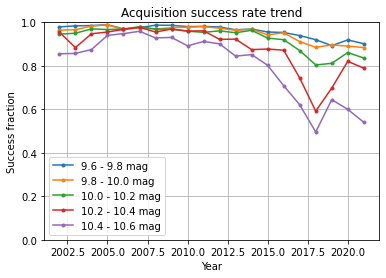

In [15]:
# Make the plot
fig, ax = plt.subplots()
imags = sorted(set(sga['imag']))
for imag in imags:
    ok = sga['imag'] == imag
    ax.plot(sga['iyear'][ok], sga['star_tracked'][ok], '-o', ms=3,
            label=f'{imag:.1f} - {imag+0.2:.1f} mag')
ax.legend()
ax.grid()
ax.set_title('Acquisition success rate trend')
ax.set_ylabel('Success fraction')
ax.set_xlabel('Year')
ax.set_ylim(0, 1);
plt.savefig('acq_success_yearly.png', dpi=150)


In [16]:
sga.write('acq_success_yearly.csv', overwrite=True)